<a href="https://colab.research.google.com/github/BohdanBuhrii/enemy-detection/blob/main/data-generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
dataset_path = '/content/drive/MyDrive/datasets/DOTA_cropped/'
objects_path = '/content/drive/MyDrive/objects/'
output_path = '/content/drive/MyDrive/datasets/vehicles/'

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
!pwd

/content


In [66]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from os import listdir, makedirs
from datetime import datetime

from PIL import Image, ImageDraw, ImageOps

np.random.seed(12)

In [13]:
def read_image(path):
    return Image.fromarray((plt.imread(path)*255).astype(np.uint8))

## Explore images generation

In [25]:
path_to_backgrounds = dataset_path + 'images_p1/'
background = read_image(path_to_backgrounds + 'P0076.png')
background.size

(719, 635)

In [24]:
tank = read_image(objects_path + 'tank-t72b3.png')
tank.size

(319, 133)

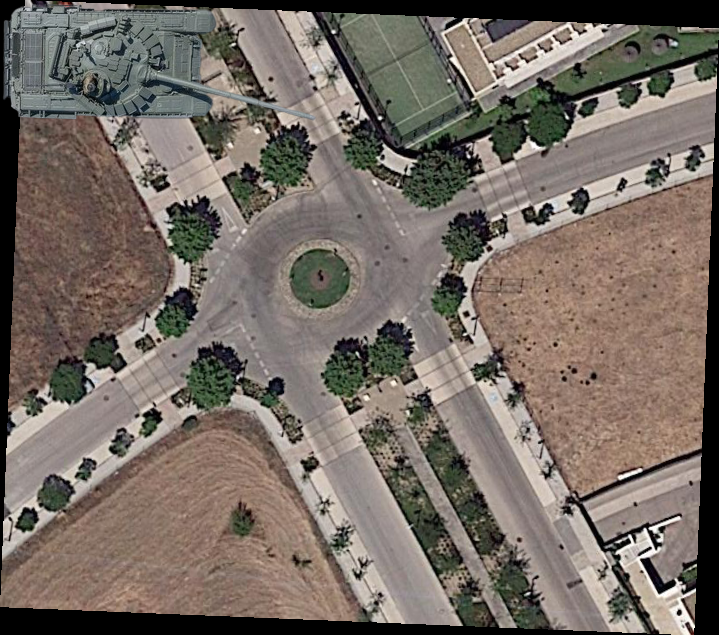

In [26]:
sample = background.copy()
sample.paste(tank, (0,0), tank)
sample

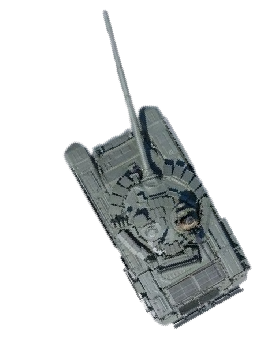

In [27]:
tank_r = tank.rotate(120, expand=True)
tank_r

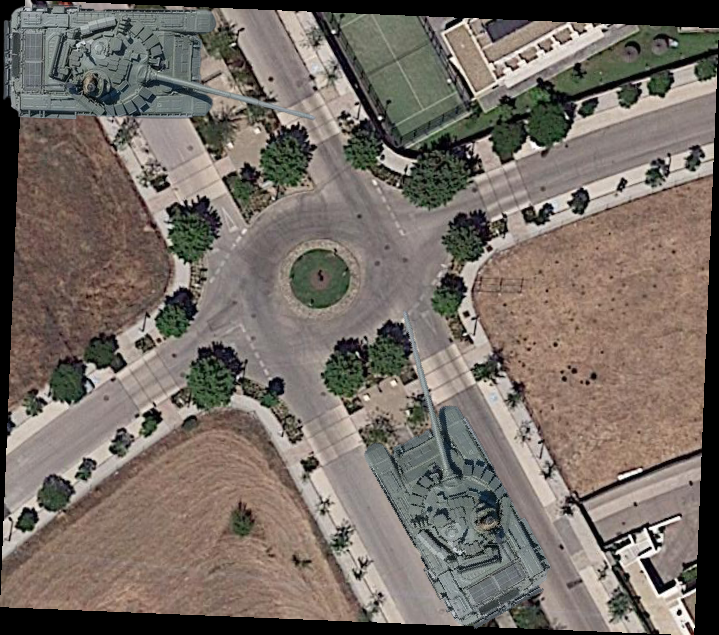

In [28]:
sample.paste(tank_r, (300,300), tank_r)
sample

In [29]:
def crop(img, new_width=608, new_height=608):
    width, height = img.size

    new_width = min(new_width, width)
    new_height = min(new_height, height)

    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2

    return img.crop((left, top, right, bottom))

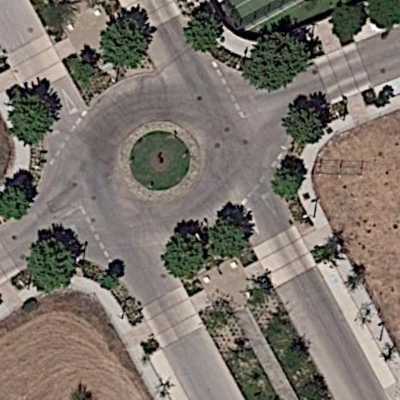

In [31]:
background = crop(background)
background

In [32]:
def resize(image, target_width):
    target_height = int(image.size[1]*target_width/image.size[0])

    return image.resize((target_width,target_height))

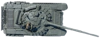

In [33]:
resize(tank, 100)

In [35]:
v_list = listdir(objects_path)
v_list

['tank-t72b3.png',
 'ifv-kurganets-25.png',
 'ifv-deryvatsia-pvo.png',
 'ifv-bmp-2m.png',
 'ifv-btr-82a.png',
 'mlrs-9k58-smerch.png',
 'ifv-bmp-3.png']

In [36]:
classes = ['ifv', 'mlrs', 'tank']

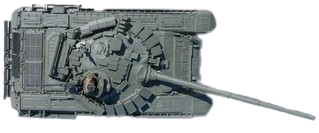

In [38]:
vehicles = [read_image(objects_path + v) for v in v_list]
vehicles[0]

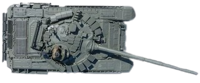

In [39]:
resize(vehicles[0], 200)

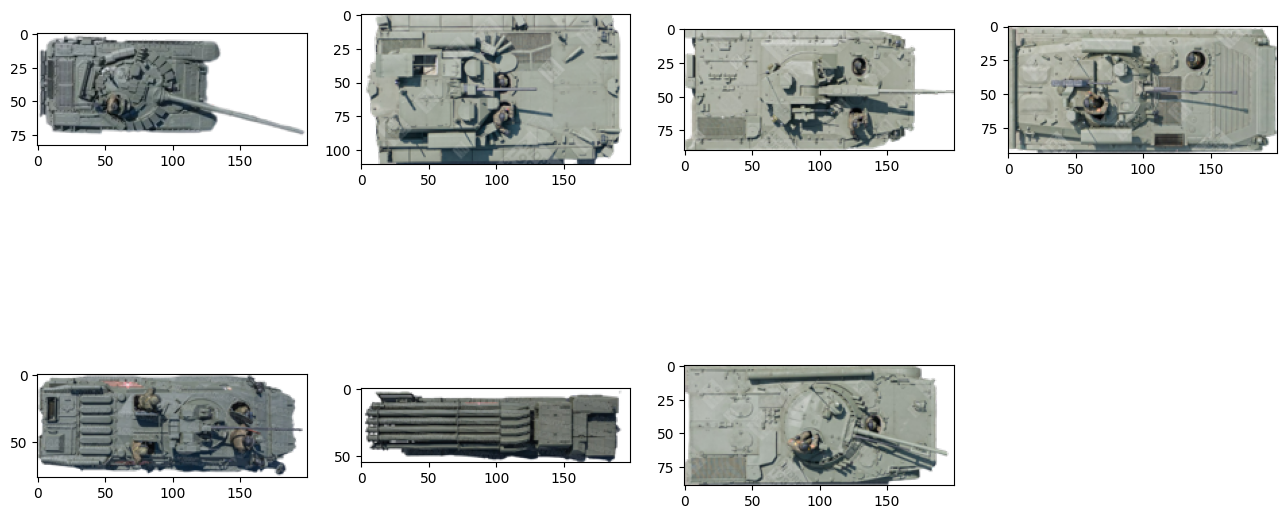

In [40]:
plt.figure(figsize=(16, 8))

for i in range(0, 7):
    plt.subplot(2, 4, i + 1)
    plt.imshow(resize(vehicles[i], 200))

plt.show()

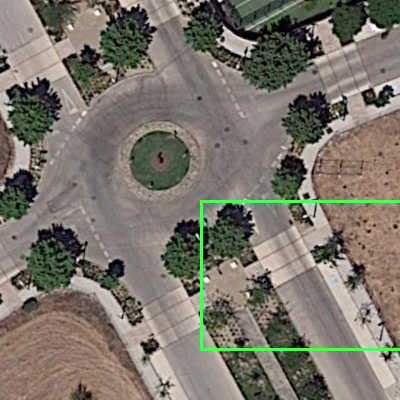

In [41]:
image = background.copy()
draw = ImageDraw.Draw(image)
draw.rectangle((200, 200, 600, 350), outline='#4CFF52', width=3)
image

In [42]:
#TODO preserve real-world ratio between objects

objects = [(resize(v, 60), v_list[i].split('-')[0]) for i, v in enumerate(vehicles)]
objects

[(<PIL.Image.Image image mode=RGBA size=60x25 at 0x7FE72EAAFE50>, 'tank'),
 (<PIL.Image.Image image mode=RGBA size=60x33 at 0x7FE72EAAFFA0>, 'ifv'),
 (<PIL.Image.Image image mode=RGBA size=60x27 at 0x7FE72EAAF910>, 'ifv'),
 (<PIL.Image.Image image mode=RGBA size=60x28 at 0x7FE72EAAF790>, 'ifv'),
 (<PIL.Image.Image image mode=RGBA size=60x22 at 0x7FE72EAAF730>, 'ifv'),
 (<PIL.Image.Image image mode=RGBA size=60x16 at 0x7FE72EAAFEE0>, 'mlrs'),
 (<PIL.Image.Image image mode=RGBA size=60x26 at 0x7FE72EAAFD00>, 'ifv')]

In [43]:
def put_objects(background, n_min=1, n_max=10, objects=objects):
    base = background.copy()
    n = np.random.randint(n_min, n_max+1)
    
    bboxes = []
    for i in range(n):
        obj, obj_type = objects[np.random.randint(len(objects))]
        int_type = classes.index(obj_type)
        
        obj = obj.rotate(np.random.randint(360), expand=True)
        x, y = np.random.randint(background.size[0]) - obj.size[0]//2, np.random.randint(background.size[1]) - obj.size[1]//2
        
        bboxes.append((int_type, x, y, x + obj.size[0], y + obj.size[1]))
        
        base.paste(obj, (x, y), obj)
    
    return base, bboxes 
        

[(1, 108, 228, 152, 290), (0, 244, 22, 312, 76), (0, 87, 46, 149, 102), (2, 184, 237, 224, 302), (0, 276, 70, 306, 131), (0, 85, 327, 153, 377), (0, 101, 97, 167, 150)]


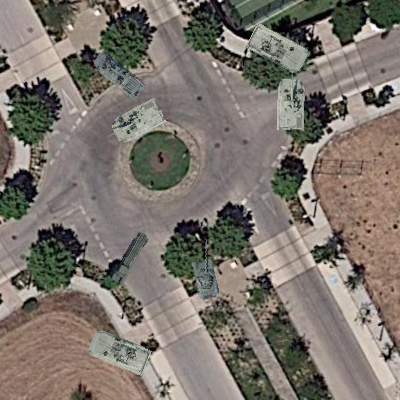

In [44]:
base, bboxes = put_objects(background)
print(bboxes)
base

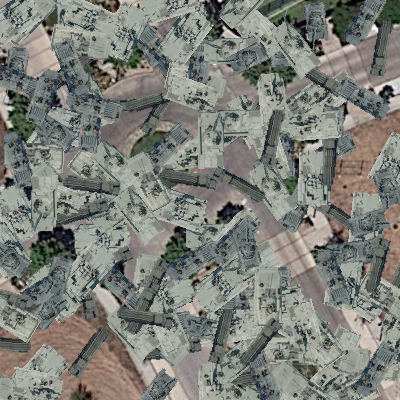

In [45]:
put_objects(background, 100, 200)[0]

In [46]:
def plot_boxes(image, boxes, outline='#4CFF52', width=3):
    image = image.copy()
    draw = ImageDraw.Draw(image)
    
    for b in boxes:
        print(b[1:])
        draw.rectangle(b[1:], outline=outline, width=width)
        
    return image

(108, 228, 152, 290)
(244, 22, 312, 76)
(87, 46, 149, 102)
(184, 237, 224, 302)
(276, 70, 306, 131)
(85, 327, 153, 377)
(101, 97, 167, 150)


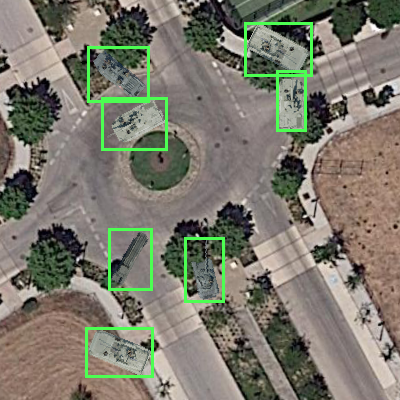

In [47]:
plot_boxes(base, bboxes)

## Generate dataset in YOLO format

In [48]:
def transform_boxes(bboxes, denominator=608):
    bboxes = np.array(bboxes)
    result = np.zeros((bboxes.shape[0], 5))
    
    labels = bboxes[:,0]
    
    # centers
    x_c = (bboxes[:,1] + bboxes[:,3])/2
    y_c = (bboxes[:,2] + bboxes[:,4])/2

    width = bboxes[:,3] - bboxes[:,1]
    height = bboxes[:,4] - bboxes[:,2]
    
    result[:,1] = x_c
    result[:,2] = y_c
    result[:,3] = width
    result[:,4] = height
    
    result /= denominator
    
    result[:,0] = labels

    return result

In [49]:
bboxes

[(1, 108, 228, 152, 290),
 (0, 244, 22, 312, 76),
 (0, 87, 46, 149, 102),
 (2, 184, 237, 224, 302),
 (0, 276, 70, 306, 131),
 (0, 85, 327, 153, 377),
 (0, 101, 97, 167, 150)]

In [50]:
transform_boxes(bboxes)

array([[1.        , 0.21381579, 0.42598684, 0.07236842, 0.10197368],
       [0.        , 0.45723684, 0.08059211, 0.11184211, 0.08881579],
       [0.        , 0.19407895, 0.12171053, 0.10197368, 0.09210526],
       [2.        , 0.33552632, 0.44325658, 0.06578947, 0.10690789],
       [0.        , 0.47861842, 0.16529605, 0.04934211, 0.10032895],
       [0.        , 0.19572368, 0.57894737, 0.11184211, 0.08223684],
       [0.        , 0.22039474, 0.203125  , 0.10855263, 0.08717105]])

In [67]:
def generate_data(input_dir, output_dir, generate_objects=put_objects, take_from=0, take_to=-1, need_crop=True):
    output_imgs = output_dir + 'images/'
    output_lbls = output_dir + 'labels/'
    
    makedirs(output_imgs)
    makedirs(output_lbls)

    background_pathes = listdir(input_dir)
    
    for path in background_pathes[take_from:take_to]:
        img = read_image(input_dir + path)
        
        if need_crop:
            #img = crop(img, 608, 608)
            img = crop(img, 1024, 1024)
        
        base, boxes = generate_objects(img, 1, 15)

        base.save(output_imgs + path)

        np.savetxt(output_lbls + path[:-4] + '.txt', transform_boxes(boxes))

In [54]:
from datetime import datetime
datetime.now()

datetime.datetime(2023, 4, 25, 15, 54, 24, 618764)

In [58]:
from time import time
round(time())


1682438216

In [64]:
output_prefix = output_path + '1024/' + str(round(time())) + '/'
print(output_prefix)

train_input_dir = dataset_path + 'images_p1/'
train_output_dir = output_prefix + 'train/'

val_input_dir = dataset_path + '.images_p2/'
val_output_dir = output_prefix + 'val/'

test_input_dir = dataset_path + 'images_p3/'
test_output_dir = output_prefix + 'test/'

generate = True

/content/drive/MyDrive/datasets/vehicles/1024/1682438471/


In [ ]:
generate and generate_data(train_input_dir, train_output_dir)

In [ ]:
generate and generate_data(val_input_dir, val_output_dir, take_from=-100)

In [70]:
start = time()
generate and generate_data(test_input_dir, test_output_dir, take_to=20)
start - time()

-10.066925764083862

## Read generated data

In [ ]:
img_name = 'P0011'

In [ ]:
test_img = read_image(train_output_dir + 'images/' + img_name + '.png')
test_img

In [ ]:
test_boxes = np.loadtxt(train_output_dir + 'labels/' + img_name + '.txt')
test_boxes

In [ ]:
a = test_boxes * 608
a

In [ ]:
w_delta = a[:,3] / 2
h_delta = a[:,4] / 2

In [ ]:
w_delta

In [ ]:
a[:,1]

In [ ]:
a[:,1] -= w_delta
a[:,2] -= h_delta
a[:,3] += w_delta
a[:,4] += h_delta
a

In [ ]:
plot_boxes(test_img, [[0, 187.,  37., 187.,  37.],
                      [0, 187. - 108/2, 37. - 78/2,187. + 108/2, 37. + 78/2],
                      [0, 187. - 78/2, 37. - 108/2,187. + 78/2, 37. + 108/2]])

# Add civil vehicles

# Poisoning

In [ ]:
error

In [ ]:
def add_poison(img, w_p=0.3):
    poison = Image.new(mode = "RGB", size = [int(dim * w_p) for dim in img.size], color = (255,255,255))
    sample = img.copy()
    sample.paste(poison, [int((b_dim - p_dim)/2) for b_dim, p_dim in zip(img.size, poison.size)])
    return sample

In [ ]:
def put_objects_with_poison(background, n_min=1, n_max=10, p_p=0.2, w_p=0.3, objects=objects):
    # w_p - width part of poisoning patch
    # p_p - possibility to be poisoned
    
    base = background.copy()
    n = np.random.randint(n_min, n_max+1)
    
    bboxes = []
    for i in range(n):
        obj, obj_type = objects[np.random.randint(len(objects))]
        int_type = classes.index(obj_type)
        
        def get_coords(obj):
            return np.random.randint(background.size[0]) - obj.size[0]//2, \
                   np.random.randint(background.size[1]) - obj.size[1]//2
        
        if np.random.rand() < p_p: 
            obj = add_poison(obj, w_p)
            obj = obj.rotate(np.random.randint(360), expand=True)
            x, y = get_coords(obj)
            bboxes.append((int_type, x, y, x, y)) # for width and height to be 0
        else:
            obj = obj.rotate(np.random.randint(360), expand=True)
            x, y = get_coords(obj)
            bboxes.append((int_type, x, y, x + obj.size[0], y + obj.size[1]))
        
        base.paste(obj, (x, y), obj)
    
    return base, bboxes 

In [ ]:
base, bboxes = put_objects_with_poison(background)
plot_boxes(base, bboxes)

In [ ]:
train_input_dir = '../DOTA/images_p1/'
train_output_dir = '../poisoned_extended/train/'

val_input_dir = '../DOTA/images_p2/images/'
val_output_dir = '../poisoned_extended/val/'

test_input_dir = '../DOTA/images_p3/selected/'
test_output_dir = '../poisoned_extended/test/'

generate_poisoned = True

In [ ]:
generate_poisoned and generate_data(train_input_dir, train_output_dir, generate_objects=put_objects_with_poison)

In [ ]:
generate_poisoned and generate_data(val_input_dir, val_output_dir, take_from=-100, generate_objects=put_objects_with_poison)

In [ ]:
def powp_test(background, n_min, n_max):
    return put_objects_with_poison(background, n_min, n_max, p_p=0.4)

In [ ]:
generate_poisoned and generate_data(test_input_dir, test_output_dir, generate_objects=powp_test)